# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [2]:
# Reinstalling torch with the right CUDA bindings.
!pip3 install -U https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
!pip3 install -U https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 770.7MB 30kB/s 
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
     |████████████████████████████████| 2.6MB 1.6MB/s 
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0


In [0]:
# Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [4]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'n_classes': 10,      # Number of classes.
    'lr': 1e-4,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 200,    # Mini-batch size.
    'w_size': 224,        # Width size for image resizing.
    'h_size': 224,        # Height size for image resizing.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# O pacote Torchvision

Assim como no MXNet, o subpacote [datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) do [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) do Pytorch possui dataloaders para vários datasets conhecidos da literatura de Visão Computacional. O CIFAR10, já usado previamente no curso, é um desses dataset clássicos de classificação que possuem implementações que podem ser carregados por meio de uma única linha de código. Outros datasets clássicos presentes no torchvision são: MNIST (classificação), Fasion-MNIST (classificação), ImageNet (classificação), VOC (segmentação e detecção), COCO (detecção e captioning), etc. No bloco de código abaixo são carregados os datasets de treino e teste do CIFAR10 e seus respectivos dataloaders.

O torchvision também possui outras funções de apoio ao treino de modelos para Deep Learning em imagens, como a definição de modelos (pré-treinados ou não) no subpacote [models](https://pytorch.org/docs/stable/torchvision/models.html) e a possibilidade de realizar pré-processamentos em imagens (incluindo Data Augmentation) por meio de transformações comuns em imagens no subpacote [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html). Essas transformações também são demonstradas no código abaixo.

Files already downloaded and verified


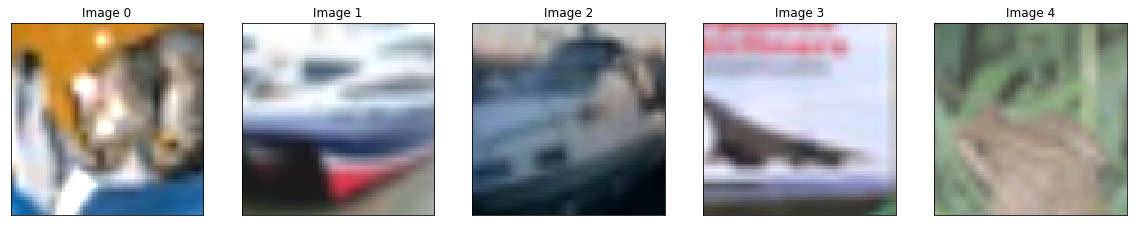

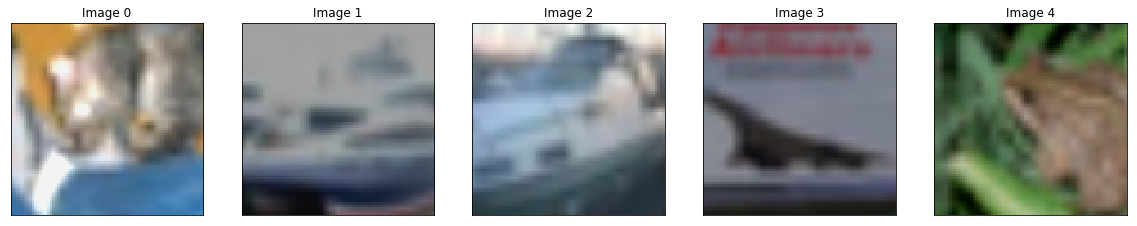

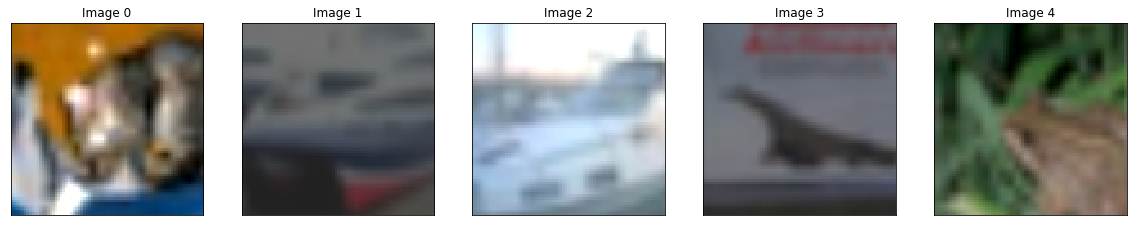

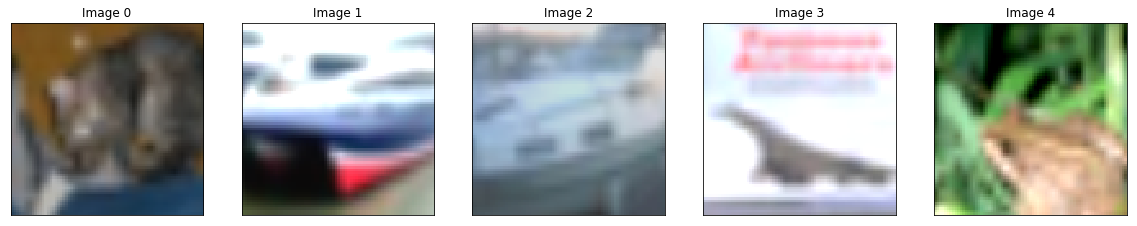

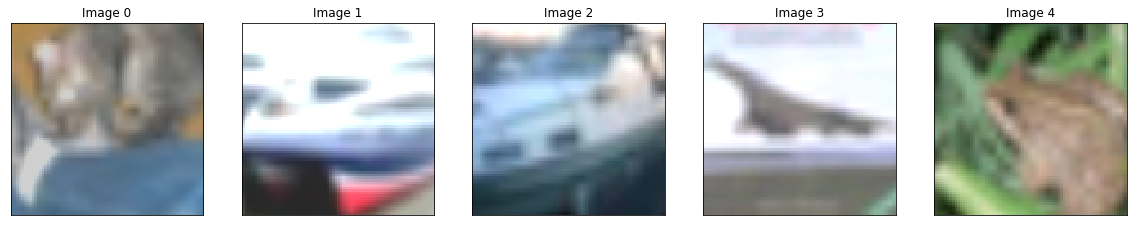

In [15]:
# Root directory for the dataset (to be downloaded).
root = './'

# Data Augmentation transforms.
data_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomCrop((75, 75)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),
])

# Setting datasets and dataloaders.
train_set = datasets.CIFAR10(root,
                             train=True,
                             download=True,
                             transform=data_transform)
test_set = datasets.CIFAR10(root,
                            train=False,
                            download=False,
                            transform=data_transform)
    
for iters in range(5):
    
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))

    for i, test_data in enumerate(test_set):

        if i >= 5:
            break
    
        test_img, _ = test_data

        ax[i].imshow(test_img.numpy().transpose(1, 2, 0))
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_title('Image ' + str(i))
        
    plt.show()

In [0]:
# Root directory for the dataset (to be downloaded).
root = './'

# Setting transforms (resizing, conversion to tensor and normalizing).
data_transform = transforms.Compose([
    transforms.Resize((args['h_size'], args['w_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Setting datasets and dataloaders.
train_set = datasets.CIFAR10(root,
                             train=True,
                             download=True,
                             transform=data_transform)
test_set = datasets.CIFAR10(root,
                            train=False,
                            download=False,
                            transform=data_transform)

train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Files already downloaded and verified
Size of training set: 50000 samples
Size of test set: 10000 samples


# Programação Orientada a Objetos

Faz-se necessário o uso de  [Programação Orientada a Objetos](https://www.tutorialspoint.com/python/python_classes_objects.htm) (POO) à medida que se começa a lidar com tarefas mais específicas tratadas por algoritmos de Deep Learning. Algumas vantagens que POO trazem para a programação de algoritmos de Deep Learning são:

1.   Organização do código. Criar uma arquitetura com centenas de camadas podendo conter várias *skip connections* no meio de um bloco de código, como vínhamos fazendo anteriormente, torna o nosso código desorganizado;
2.   Reaproveitamento dos códigos básicos do framework (i.e. dataloaders, módulos/camadas de redes predefinidos, funções de perda, etc) para adaptá-los para novas tarefas minimizando a quantidade de código que necessita ser escrita;
3.   Códigos escritos em formato POO podem ser reutilizados em outros pontos da aplicação. Arquiteturas como [DenseNets](https://arxiv.org/abs/1608.06993), [ResNets](https://arxiv.org/abs/1512.03385) ou [U-Nets](https://arxiv.org/abs/1505.04597) possuem blocos de código que se repetem, os quais podem ser simplificados com o uso de POO;
4.   POO também permite uma melhor modularização do código, de forma que mudanças (i.e. loss function, arquitetura, dataloader, etc) possam ser feitas em módulos isolados sem afetar o resto do código.

No caso da implementação de modelos usando classes no Pytorch, normalmente é preciso se preocupar apenas com a implementação de dois métodos: o *\_\_init\_\_()* e o *forward()*. O *\_\_init\_\_()* é conhecido como o construtor da classe e define a arquitetura da rede neural que é implementada pela classe, ou seja, é nesse método que se definem as camadas da rede neural. Já o *forward()* serve para definir o fluxo de dados que passará pelas camadas definidas no *\_\_init\_\_()*. O *forward()* recebe sempre como entrada os dados que passarão pelo modelo e deve retornar o output do modelo após processar esses dados de entrada ao longo de suas camadas. É notável que entre as camadas convolucionais e as camadas Fully Connected, faz-se necessário chamar o método [*view()*](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) para linearizar os dados do tensor.

Também é preciso lembrar de sempre definir a classe em que o modelo está sendo implementado como subclasse de *nn.Module*.

# Redes Residuais (ResNets)

Entre 2012 e 2015 a comunidade de Visão Computacional percebeu que redes mais profundas conseguiam capturar características semânticas mais úteis dos dados para tarefas de reconhecimento de imagens (i.e. classificação, segmentação, detecção...). Porém, redes mais profundas que as maiores arquiteturas da época -- como a [VGG](https://arxiv.org/abs/1409.1556) e a [Inception](https://arxiv.org/abs/1409.4842) -- sofriam de um problema chamado **Vanishing Gradient**.

![VGG](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_W640.jpg)

![Inception](https://miro.medium.com/max/700/1*uW81y16b-ptBDV8SIT1beQ.png)


O **Vanishing Gradient** se torna mais problemático em redes mais profundas porque o gradiente dos erros precisa backpropagar desde a última camada até o começo da rede. Dessa forma, as últimas camadas conseguem ser treinadas de forma eficiente, mas o gradiente dos erros vai desaparecendo à medida em que backpropaga pela rede, praticamente impossibilitando o treinamento das primeiras camadas. Assim, foi constatado que uma rede com, por exemplo, 34 camadas acabava por conseguir resultados piores que uma rede com apenas 18 camadas.

![Rede Não Residual](https://www.dropbox.com/s/pq190al5b3qv194/normal_18_vs_34_layers.png?dl=1)

No final de 2015 foi proposta uma solução para o **Vanishing Gradient** na forma de **Blocos Residuais** que, juntos, formam **Redes Residuais** [**(ResNets)**](https://arxiv.org/abs/1512.03385). Esses blocos residuais recebem uma entrada $x$ e a alimentam para um bloco convolucional ($\mathcal{F}(x)$) composto por:

1.   Convolução 3x3;
2.   Batch Normalization;
3.   ReLU;
4.   Convolução 3x3;
5.   Batch Normalization.

A saída $\mathcal{F}(x)$ desse bloco, antes de ser passada por uma segunda ReLU, é passada em conjunto com a entrada $x$ para uma função identidade, que, no caso das **ResNets**, é uma simples soma. Dessa forma, a saída final de um **Bloco Residual** é dada por: $\mathcal{F}(x) + x$. O esquema de um **Bloco Residual** pode ser visto na figura abaixo.

![Bloco Residual](https://www.dropbox.com/s/ezydump33p95ohc/residual_block.png?dl=1)

Como pode ser visto na imagem a seguir, com o uso de blocos residuais, uma arquitetura com 34 camadas consegue resultados melhores que uma arquitetura com apenas 18 camadas. Esses resultados evidenciam que o uso da soma como **identity function** de fato permite que o backward treine mais efetivamente as primeiras camadas das **ResNets**. **ResNets** permitiram que CNNs chegassem até a casa das 100 camadas. A maior **ResNet** usada na prática possui 152 camadas, o que a deixa impraticável de imprimir numa figura como é mostrado abaixo na ResNet34.

![Rede Residual](https://www.dropbox.com/s/q4wcjwf8qj4xjrn/resnet_18_vs_34_layers.png?dl=1)

Como pode ser visto nas imagens abaixo, ResNets (e outras arquiteturas modernas como a [VGG](https://arxiv.org/abs/1409.1556) e as [DenseNets](https://arxiv.org/abs/1608.06993) são compostas basicamente de convoluções com kernels de tamanho 3x3. Além disso, é notável na arquitetura residual (à direita) a presença dos "atalhos" para o gradiente  na forma das funções identidade que ajudam no treinamento das primeiras camadas durante o backpropagation.

![VGG vs. Plain34 vs. ResNet34](https://www.dropbox.com/s/d2w3h7dlumgclx2/vgg_plain34_resnet34.png?dl=1)

# Atividade Prática

1.   Completar a classe *ResidualBlock()*. Devem ser complementados os métodos *\_\_init\_\_()* e *forward()*. Atenção para a implementação da função identidade no *forward()* e para a compatibilidade do número de canais de entrada e saída de cada bloco residual. Quando a variável *in_planes* tiver um valor diferente da *out_planes*, uma convolução 1x1 deve ser instanciada para transformar o número de canais da entrada *in_planes* nos feature maps para *out_planes*. Isso vai permitir que blocos residuais que tenham números de canais entrada e saída diferentes possam ser somados no *forward()* para o cálculo da função identidade.
2.   Completar a classe ResNet criando um bloco convolucional no começo da rede, dois blocos residuais no meio. Novamente devem ser implementados os métodos *\_\_init\_\_()* e *forward()*.
3.   Definir o otimizador que fará a rede convergir. Podem ser escolhidos diferentes otimizadores de acordo com o que está implementado no pacote [*optim*](https://pytorch.org/docs/stable/optim.html).
4.   Definir a loss function de acordo com o pacote [*nn*](https://pytorch.org/docs/stable/nn.html#loss-functions) que será utilizada para computar os gradientes no fim da rede. Deve ser escolhida a Cross Entropy, já que trata-se de uma tarefa de classificação de imagens.
5.   Opcional: adicionar transformações diferentes nos dados (i.e. flips horizontais/verticais aleatórios, crops aleatórios, color jitter, rotações aleatórias, etc) usando o pacote [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) para realizar Data Augmentation.

As funções de treino e teste já estão implementadas.

In [0]:
# Implementation of residual block to be reused.
class ResidualBlock(nn.Module):
    
    def __init__(self, in_planes, out_planes):
        
        super(ResidualBlock, self).__init__()
        
        # TO DO: define first and second convolutional blocks.
        
        # If in_planes != out_planes, perform a 1x1 conv to match #channels.
        self.conv1x1 = None
        if in_planes != out_planes:
            self.conv1x1 = # TO DO: define 1x1 convolution.
            

    def forward(self, x):
        
        identity = x

        # TO DO: forward on first conv block.
        
        # TO DO: forward on second conv block.
        
        # TO DO: return output.

# ResNet18 implementation.
class ResNet(nn.Module):
    
    def __init__(self, num_classes=10):

        super(ResNet, self).__init__()

        # TO DO: define first convolutional block:
        #        1. conv with 7x7 kernel, 64 output channels, stride of 2,
        #           padding of 3 and with no bias;
        #        2. 2d batch normalization;
        #        3. ReLU;
        #        4. 2d max pool with 3x3 kernel, stride of 2 and padding of 1.


        # TO DO: define first residual block + pooling:
        #        1. instantiate residual block from class ResidualBlock with
        #           number of output channels equal to 128;
        #        2. 2d max pool with 3x3 kernel, stride of 2 and padding of 1.
        
        
        # TO DO: define second residual block + pooling:
        #        1. instantiate residual block from class ResidualBlock with
        #           number of output channels equal to 128;
        #        2. 2d max pool with 3x3 kernel, stride of 2 and padding of 1.
        
        # TO DO: define classifier:
        #        1. define an nn.AdaptiveAvgPool2d(output_size(1, 1)), simmilar
        #           to MXNet's GlobalPool2d();
        #        2. define FC classification layer with 10 outputs.
        self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.classifier = nn.Linear(128, num_classes)
        
        self.initialize_weights()
    
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        
        # TO DO: forward on first conv block.
        
        # TO DO: forward on first residual block.
        
        # TO DO: forward on second residual block.
        
        # TO DO: forward on adaptive_pool.
        
        # TO DO: linearizing tensor to serve as input to FC layer.
        
        # TO DO: obtain 10 predictions (one for each class) on FC layer.
        
        # TO DO: return output.

# Instantiating architecture.
net = ResNet(args['n_classes']).to(args['device'])

# Printing architecture.
print(net)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_block1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_block2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (co

# Definindo o otimizador

O Pytorch possui vários otimizadores prontos no subpacote [optim](https://pytorch.org/docs/stable/optim.html), desde o SGD básico a otimizadores mais complexos e com taxas de aprendizado por parâmetro como o Adagrad, RMSProp e Adam.

In [0]:
# TO DO: define optimizer.

# Definindo a loss

O subpacote [nn](https://pytorch.org/docs/stable/nn.html) possui várias funções de perda para diferentes tarefas (i.e. Cross Entropy, Negative Log Likelihood, loss L1, MSE, Kullback Leibler Divergence, etc) implementadas por padrão.



In [0]:
# TO DO: define loss function.

# Criando funções para Treino e Teste

Iterando sobre os datasets/dataloaders de treino e teste do CIFAR10. Abaixo são implementadas a função *train()* que itera sobre os batches do dataset de treino e atualiza o modelo e a função *test()* que apenas realiza o forward dos dados de teste no modelo e calcula a acurácia no dataset de teste para o modelo no estado atual.

In [0]:
def train(train_loader, net, criterion, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images, labels and paths for batch.
        inps, labs = batch_data
        
        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])
        
        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs = net(inps)

        # Computing loss.
        loss = criterion(outs, labs)

        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Updating lists.
        train_loss.append(loss.data.item())
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss.mean(), train_loss.std(), (toc - tic)))
    print('--------------------------------------------------------------------')
    
def test(test_loader, net, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode (not computing gradients).
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    prd_list = []
    lab_list = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images, labels and paths for batch.
        inps, labs = batch_data

        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        # Forwarding.
        outs = net(inps)

        # Computing loss.
        loss = criterion(outs, labs)
        
        # Obtaining predictions.
        prds = outs.data.max(dim=1)[1].cpu().numpy()
        
        # Updating lists.
        test_loss.append(loss.data.item())
        prd_list.append(prds)
        lab_list.append(labs.detach().cpu().numpy())
    
    toc = time.time()
    
    # Computing accuracy.
    acc = metrics.accuracy_score(np.asarray(lab_list).ravel(),
                                 np.asarray(prd_list).ravel())
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f], [acc %.4f], [testing time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), acc, (toc - tic)))
    print('--------------------------------------------------------------------')

# Iterando sobre epochs

In [0]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, criterion, epoch)

--------------------------------------------------------------------
[epoch 1], [train loss 1.9300 +/- 0.1636], [training time 141.58]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 1], [test loss 1.7238 +/- 0.0427], [acc 0.3883], [testing time 96.30]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 2], [train loss 1.6129 +/- 0.0696], [training time 141.92]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 2], [test loss 1.5302 +/- 0.0484], [acc 0.4566], [testing time 96.04]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 3], [train loss 1.4665 +/- 0.0566], [training time 141.75]
---------------------------